In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split

from plotnine import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import FeatureHasher


pd.options.mode.chained_assignment = None  # default='warn'

In [180]:
data = pd.read_csv('train.csv')

In [181]:
data.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,...,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,...,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,...,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


# Q1

In [182]:
Y = data['target'].values
X = data.drop(columns=['target'])

In [183]:
x_train_val, x_test, y_train_val, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 5)

In [184]:
binary_cols = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']
x_train_val = pd.get_dummies(x_train_val, columns=binary_cols)
x_test = pd.get_dummies(x_test, columns=binary_cols)

In [185]:
ordinal_cols = ['ord_0', 'ord_3', 'ord_4', 'ord_5']
label_encoder = LabelEncoder()
for col in ordinal_cols:
    x_train_val[col] = label_encoder.fit_transform(x_train_val[col])
    x_test[col] = label_encoder.fit_transform(x_test[col])

In [193]:
x_train_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240000 entries, 117722 to 297827
Data columns (total 29 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       240000 non-null  int64 
 1   nom_0    240000 non-null  object
 2   nom_1    240000 non-null  object
 3   nom_2    240000 non-null  object
 4   nom_3    240000 non-null  object
 5   nom_4    240000 non-null  object
 6   nom_5    240000 non-null  object
 7   nom_6    240000 non-null  object
 8   nom_7    240000 non-null  object
 9   nom_8    240000 non-null  object
 10  nom_9    240000 non-null  object
 11  ord_0    240000 non-null  int64 
 12  ord_1    240000 non-null  object
 13  ord_2    240000 non-null  object
 14  ord_3    240000 non-null  int64 
 15  ord_4    240000 non-null  int64 
 16  ord_5    240000 non-null  int64 
 17  day      240000 non-null  int64 
 18  month    240000 non-null  int64 
 19  bin_0_0  240000 non-null  bool  
 20  bin_0_1  240000 non-null  bool  
 21  bin_1_0  2

In [61]:
hashing_cols = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_1', 'ord_2']
dimensions = [3, 5, 10, 15, 20]

In [202]:
def hash_encode(data, cols, n_features):
    hashed = pd.DataFrame()
    for i in range(len(cols)):
        x_i = data[cols[i]].astype(str)
        hashed_i = hashing_trick(x_i, n_features = n_features)
        hashed = pd.concat([hashed, hashed_i], axis=1)
        data.drop(columns = cols, inplace = True)
        hashed_data_list = [data.reset_index(), hashed.reset_index()]
        return pd.concat(hashed_data_list, axis=1)

In [203]:
def hashing_trick(x: pd.DataFrame, n_features: int = 3) -> pd.DataFrame:
  """Create a hash from a column of strings.

  Args:
    x (pd.DataFrame): A single column as a pandas data frame.
    n_features (int): The number of features (columns) in the output matrices.

  Returns:
    A pandas data frame with 1 row and `n_features` columns containing the
    hashed values.
  """

  # Create new columns for output data frame.
  names = [x.name + "_" + str(i + 1) for i in range(n_features)]

  # Build hasher function.
  h = FeatureHasher(input_type = 'string', n_features = n_features)

  # Transform the column and convert to an array.
  hashed = h.transform(x.to_numpy().reshape(-1, 1)).toarray()

  # Add `names` and return hashed field.
  return pd.DataFrame(hashed, columns = names)

In [204]:
cv = KFold(n_splits=5, random_state=13, shuffle=True)

In [209]:
best_auc = 0
auc_d = []
best_dimension = None

In [215]:
for d in dimensions:
    auc_d_fold = []
    for train_fold, val_fold in cv.split(x_train_val):
        print('.', end ='')
        x_train_fold = x_train_val.iloc[train_fold, :].copy()
        x_val_fold = x_train_val.iloc[val_fold, :].copy()
        y_train_fold = y_train_val[train_fold].copy()
        y_val_fold = y_train_val[val_fold].copy()
        x_train_fold = hash_encode(x_train_fold, hashing_cols, d)
        x_val_fold = hash_encode(x_val_fold, hashing_cols, d)
        scaler = StandardScaler()
        scaler.fit(x_train_fold)
        x_train_fold_scaled = scaler.transform(x_train_fold)
        x_val_fold_scaled = scaler.transform(x_val_fold)
        lr = LogisticRegression(penalty = 'l2', C = 1, random_state =13)
        lr.fit(x_train_fold_scaled, y_train_fold)
        y_val_fold_pred = lr.predict_proba(x_val_fold_scaled)[:, 1]
        aucscore = roc_auc_score(y_val_fold, y_val_fold_pred)
        auc_d_fold.append(aucscore)
    auc_d.append(auc_d_fold)


.

TypeError: list.append() takes exactly one argument (2 given)

In [216]:
mean_auc = np.mean(auc_d)

if mean_auc > best_auc:
    best_auc = mean_auc
    best_dimension = d

print(f"Best Hashing Dimension: {best_dimension}")
print(f"Cross-validated AUC: {best_auc}")

Best Hashing Dimension: 3
Cross-validated AUC: 0.7072987454722004


In [ ]:
unique_hash_values = np.unique(x_train_hashed)
len(unique_hash_values)

In [64]:
for d in dimensions:
    hasher = FeatureHasher(n_features=d, input_type='string')
    x_train_hashed = hasher.transform(x_train[hashing_cols].apply(lambda x: [str(val) for val in x], axis=1)).toarray()

    # Scale features
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(np.concatenate([x_train_hashed, x_train.select_dtypes(include=['int', 'float']).values], axis=1))

    # Train logistic regression model
    model = LogisticRegression(penalty='l2', C=1)
    
    # Cross-validate
    auc_scores = cross_val_score(model, x_train_scaled, y_train, cv=cv, scoring='roc_auc')
    mean_auc = np.mean(auc_scores)


    # Update best dimension if necessary
    if mean_auc > best_auc:
        best_auc = mean_auc
        best_dimension = d

# Best dimension
print(f"Best Hashing Dimension: {best_dimension}")
print(f"Cross-validated AUC: {best_auc}")

Best Hashing Dimension: 15
Cross-validated AUC: 0.7095097186306966


In [65]:
hasher = FeatureHasher(n_features=15, input_type='string')
x_train_hashed = hasher.transform(x_train[hashing_cols].apply(lambda x: [str(val) for val in x], axis=1)).toarray()
x_train_scaled = scaler.fit_transform(np.concatenate([x_train_hashed, x_train.select_dtypes(include=['int', 'float']).values], axis=1))

model = LogisticRegression(penalty='l2', C=1)
model.fit(x_train_scaled, y_train)

LogisticRegression(C=1)

In [66]:
x_test_hashed = hasher.transform(x_test[hashing_cols].apply(lambda x: [str(val) for val in x], axis=1)).toarray()
x_test_scaled = scaler.fit_transform(np.concatenate([x_test_hashed, x_test.select_dtypes(include=['int', 'float']).values], axis=1))

test_auc = roc_auc_score(y_test, model.predict_proba(x_test_scaled)[:, 1])
print(f"Out of Sample AUC: {test_auc}")

Out of Sample AUC: 0.7121871929809833


In [67]:
unique_hash_values = np.unique(x_train_hashed)
len(unique_hash_values)

13

### The number of unique hash values is less than the hashing dimension of 15. This suggests potential collisions. However since higher dimension (20) did not result in better auc score and would also create higher dimensionality of the feature space, I would still choose 15 as the hashing dimension.

# Q2

In [68]:
np.unique(y_train)

array([0, 1])

In [104]:
def reg_target_encoding(data, target, col):
    
    cv = StratifiedKFold(n_splits=5, random_state=13, shuffle=True)
    global_mean = data[target].mean()
    
    for train_idx, val_idx in cv.split(data, data[target]):
        x_train_fold = data.iloc[train_idx].copy()
        x_val_fold = data.iloc[val_idx].copy()
        
        new_col = f"{col}_mean_enc"
        x_train_fold[new_col] = np.nan
        
        mean_encoding = x_train_fold.groupby(col)[target].mean()
        data.loc[val_idx, new_col] = x_val_fold[col].map(mean_encoding)

    data[new_col].fillna(global_mean, inplace=True)                                             
    
    return data

In [145]:

def reg_target_encoding(x, y, col, stratify=False, n_splits=5, random_state=None):
    """
    Regularized Target Encoding function.

    Parameters:
    - x: DataFrame, training data.
    - y: Series, target variable.
    - col: str, the column for mean encoding.
    - stratify: bool, whether to use StratifiedKFold for cross-validation (default is False).
    - n_splits: int, number of splits for cross-validation (default is 5).
    - random_state: int, random seed for reproducibility (default is None).

    Returns:
    - x: DataFrame, with new mean encoded column added.
    """

    if stratify:
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    else:
        cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    new_col = col + '_mean_enc'
    x[new_col] = pd.Series([])

    for train_index, test_index in cv.split(x, y):
        mean_enc = pd.Series(y.loc[train_index]).groupby(x.loc[train_index][col]).mean()
        x.loc[test_index, new_col] = x.loc[test_index, col].map(mean_enc)

    x[new_col] = x[new_col].fillna(y.mean())

    return x

In [146]:
reg_target_encoding(x_train, y_train, 'ord_2')

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [105]:
def mean_encoding_test(x_train:np.array, y_train:np.array, x_test: np.array, col:str) -> np.array:
    mean_enc = pd.Series(y_train).groupby(x_train[col]).mean()
    global_mean = y_train.mean()
    new_col = col + '_mean_enc'
    x_test[new_col] = np.nan
    x_test[new_col] = x_test[col].map(mean_enc)

    x_test[new_col].fillna(global_mean, inplace=True)
    
    return x_test

In [141]:
x_train, x_test, y_train, y_test = (train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 5))

(array([99816., 33768.,     0., 19654.,     0., 22227.,     0., 60627.,
            0., 63908.]),
 array([0.22410983, 0.24209529, 0.26008075, 0.27806622, 0.29605168,
        0.31403714, 0.33202261, 0.35000807, 0.36799353, 0.38597899,
        0.40396446]),
 <BarContainer object of 10 artists>)

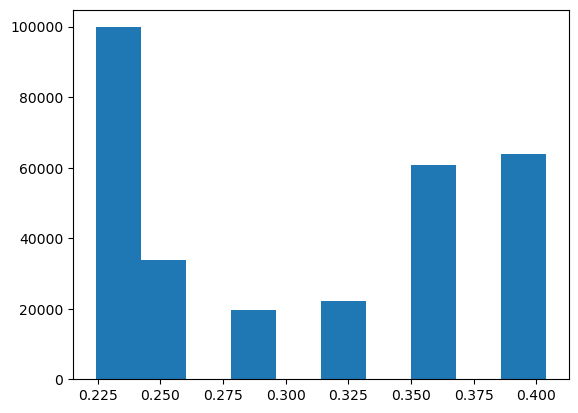

In [131]:
x_train = reg_target_encoding(data, 'target',col = 'ord_2')
plt.hist(x_train['ord_2_mean_enc'])

In [128]:
x_train['ord_2_mean_enc'].describe()

count    300000.000000
mean          0.305876
std           0.071437
min           0.224110
25%           0.225440
50%           0.289861
75%           0.361486
max           0.403964
Name: ord_2_mean_enc, dtype: float64

In [129]:
x_test = mean_encoding_test(x_train, y_train, x_test, 'ord_2')
x_test['ord_2_mean_enc'].describe()

count    60000.000000
mean         0.306498
std          0.001586
min          0.304220
25%          0.305317
50%          0.305970
75%          0.306794
max          0.310453
Name: ord_2_mean_enc, dtype: float64

(array([ 3857., 12160., 17222.,     0., 19946.,     0.,     0.,     0.,
            0.,  6815.]),
 array([0.30422014, 0.30484345, 0.30546677, 0.30609008, 0.3067134 ,
        0.30733671, 0.30796003, 0.30858334, 0.30920665, 0.30982997,
        0.31045328]),
 <BarContainer object of 10 artists>)

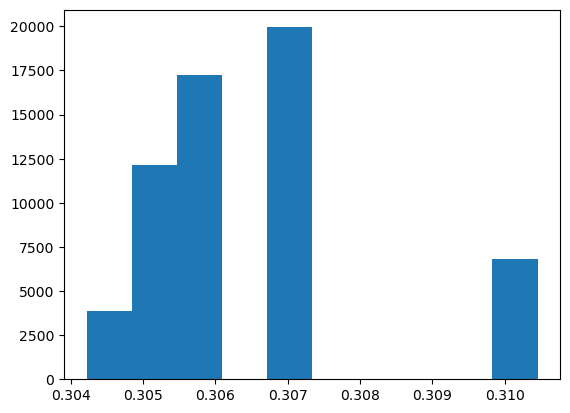

In [130]:
plt.hist(x_test['ord_2_mean_enc'])

(array([ 37444.,      0.,      0.,      0., 101295.,  45979.,  36136.,
         49659.,      0.,  29487.]),
 array([0.24340615, 0.25514884, 0.26689153, 0.27863422, 0.29037691,
        0.3021196 , 0.31386229, 0.32560498, 0.33734767, 0.34909036,
        0.36083305]),
 <BarContainer object of 10 artists>)

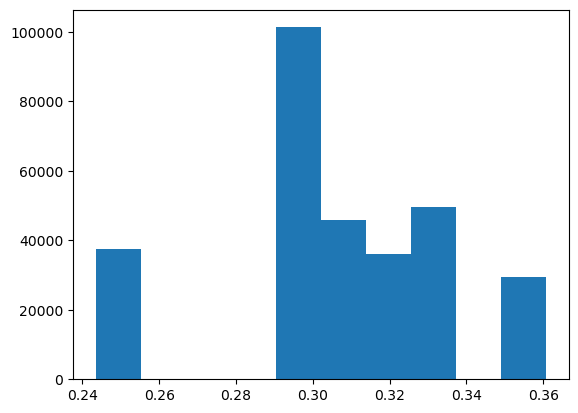

In [132]:
x_train = reg_target_encoding(data, 'target',col = 'nom_2')
plt.hist(x_train['nom_2_mean_enc'])

In [133]:
x_train['nom_2_mean_enc'].describe()

count    300000.000000
mean          0.305880
std           0.030999
min           0.243406
25%           0.292757
50%           0.307122
75%           0.334334
max           0.360833
Name: nom_2_mean_enc, dtype: float64

In [134]:
x_test = mean_encoding_test(x_train, y_train, x_test, 'nom_2')
x_test['nom_2_mean_enc'].describe()

count    60000.000000
mean         0.306491
std          0.001910
min          0.303306
25%          0.305751
50%          0.306102
75%          0.308309
max          0.308309
Name: nom_2_mean_enc, dtype: float64

(array([13118.,     0.,     0.,     0.,  9190.,  9880.,     0.,     0.,
            0., 27812.]),
 array([0.30330624, 0.30380654, 0.30430684, 0.30480713, 0.30530743,
        0.30580773, 0.30630802, 0.30680832, 0.30730862, 0.30780891,
        0.30830921]),
 <BarContainer object of 10 artists>)

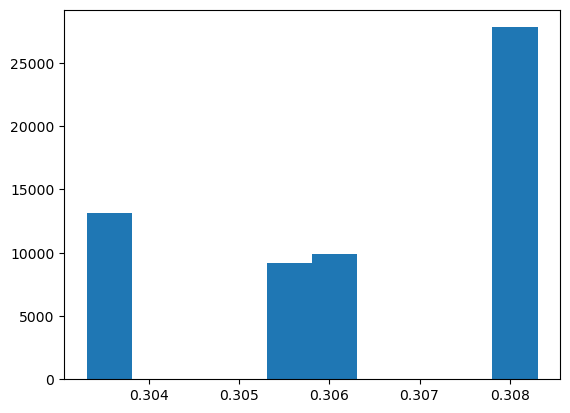

In [135]:
plt.hist(x_test['nom_2_mean_enc'])

### Mean encoding does not seem to be performing very well on the training set could be due to the size of the training data that has a larger distribution of the target variable.